# `two-pop-py` Tutorial

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as c
import astropy.units as u

import os
import shutil

au = c.au.cgs.value
M_sun = c.M_sun.cgs.value
year = u.year.to(u.s)

Here, we will use the model directly, the most general approach (not the wrappers)

In [2]:
from twopoppy import model

Make a logarithmic grid

In [3]:
n_r   = 300
n_t   = 100
r_in  = 1*au
r_out = 500*au
r     = np.logspace(np.log10(r_in),np.log10(r_out),n_r)

Set up the other input parameters and arrays; we will be using a self-similar profile, but adding a bump in the $\alpha$-viscosity

In [4]:
# model parameters

r_c    = 60*au        # disk characteristic radius [cm]
v_frag = 1000.        # fragmentation velocity [cm s^-1]
rho_s  = 1.2          # material density of dust [g cm^-3]
M_star = M_sun        # stellar mass [g]
M_disk = 0.05*M_star  # gas disk mass [g]
d2g    = 0.01         # dust-to-gas ratio [-]
a_0    = 1e-5         # initial particle size [cm]

# snapshot time [s]

time  = np.logspace(2,6,n_t)*year

# initial conditions: gas and dust surface densities [g cm^-2]

sig_g = (r/r_c)**-1*np.exp(-(r/r_c))
sig_g = sig_g/np.trapz(2*np.pi*r*sig_g,x=r)*M_disk
sig_d = d2g*sig_g

# power-law temperature [K]

T     = 200.*(r/au)**-0.5

# alpha profile: a dip at 30*au - no scientific reason

alpha = 1e-2*np.ones_like(r)-9e-3*np.exp(-(r-30*au)**2/(2*(5*au)**2))

# v_gas is only for non-evolving gas disks, where you still
# want the dust to feel a gas velocity (e.g. a steady-state disk)

v_gas = np.zeros_like(r)

Plot of the $\alpha$ profile

<IPython.core.display.Javascript object>


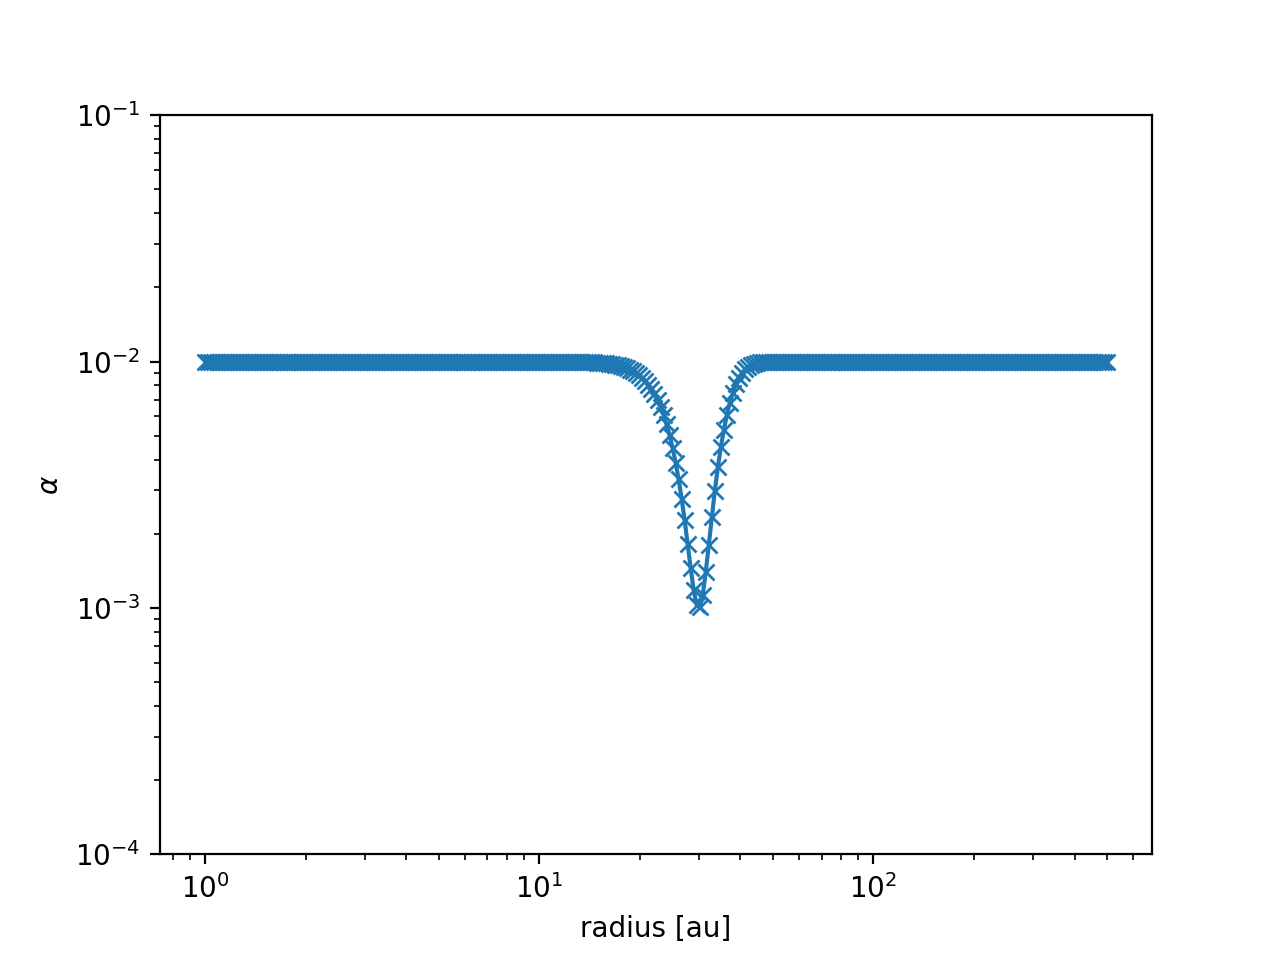

In [24]:
f,ax = plt.subplots()
ax.loglog(r/au,alpha,'-x')
ax.set_ylim(1e-4,1e-1)
ax.set_xlabel('radius [au]')
ax.set_ylabel(r'$\alpha$');

## Call the model

In [6]:
res = model.run(r, a_0, time, sig_g, sig_d, v_gas, T, alpha, M_star, v_frag, rho_s, 1)

sig_d = res[1]
sig_g = res[2]
a_t   = res[10]

toy model running ... Done!


## Plotting

Set indices of the snapshots to plot

In [7]:
IT = [20,-1]

Plot of the gas and dust surface densities

<IPython.core.display.Javascript object>


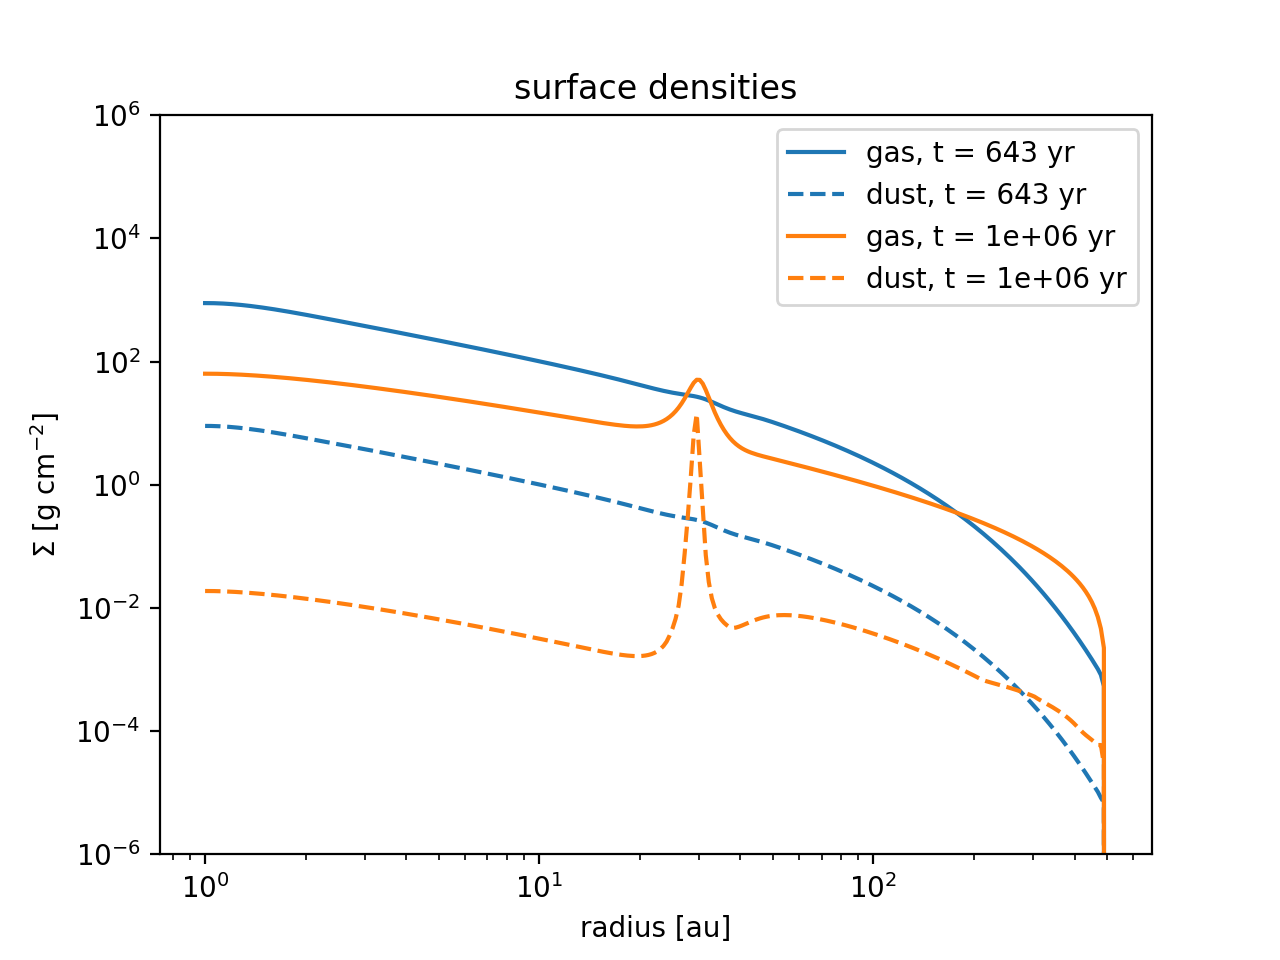

In [25]:
f, ax = plt.subplots()
for it in IT:
    l,=ax.loglog(r/au,sig_g[it,:], label='gas, t = {:.3g} yr'.format(time[it]/year))
    ax.loglog(r/au,sig_d[it,:],'--',c=l.get_color(), label='dust, t = {:.3g} yr'.format(time[it]/year))
ax.legend()
ax.set_ylim(1e-6,1e6);
ax.set_xlabel('radius [au]')
ax.set_ylabel('$\Sigma$ [g cm$^{-2}$]')
ax.set_title('surface densities');

Plot of the maximum particle size

<IPython.core.display.Javascript object>


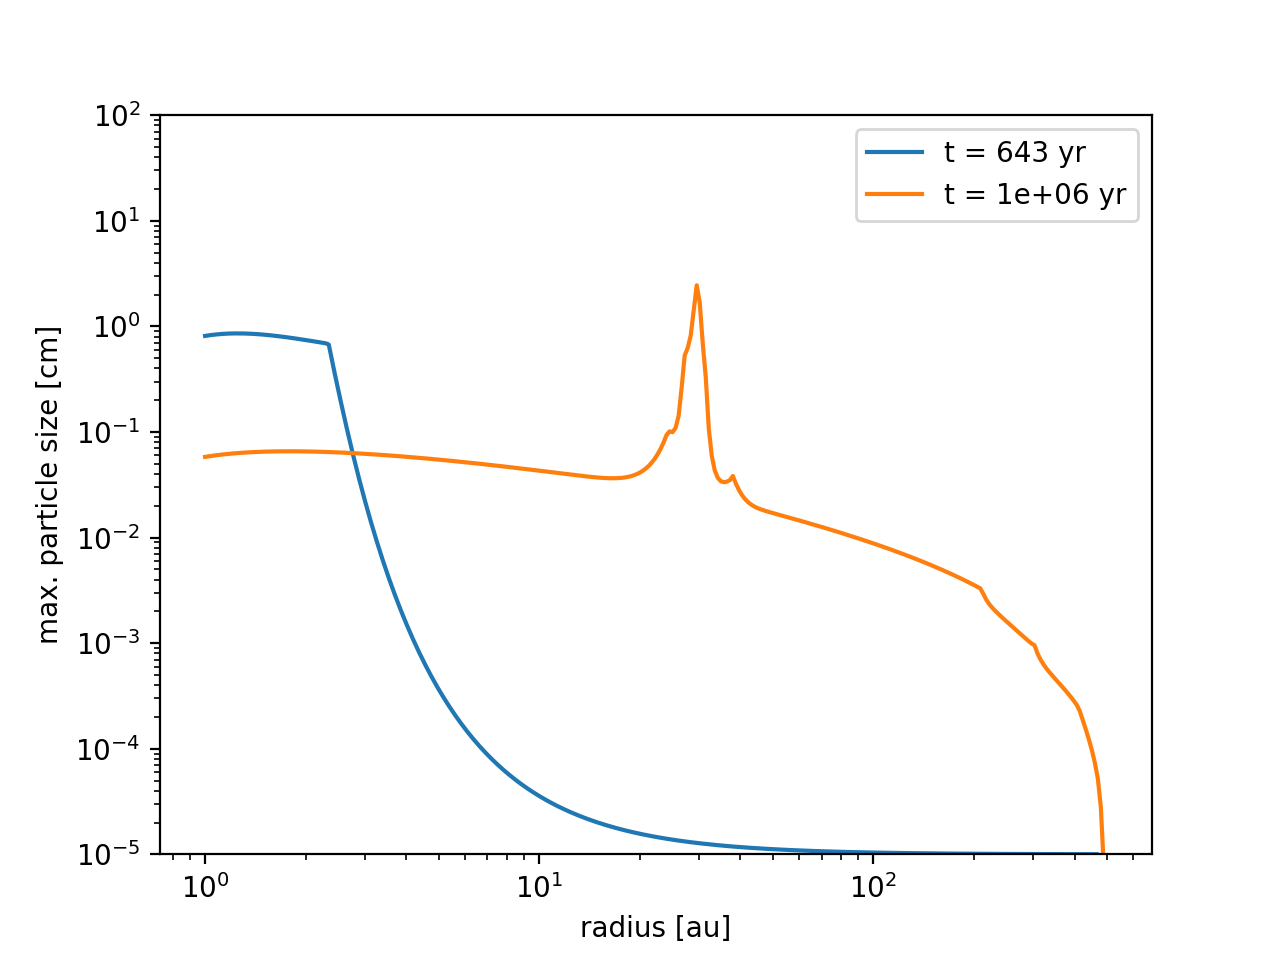

In [26]:
f, ax = plt.subplots()
for it in IT:
    ax.loglog(r/au,a_t[it,:],label='t = {:.3g} yr'.format(time[it]/year))
ax.set_ylim(1e-5,1e2)
ax.legend()
ax.set_xlabel('radius [au]')
ax.set_ylabel('max. particle size [cm]');

`widget` is my own plotting helper function to scroll through time evolving 1D or 2D distributions. You can get it [here](https://github.com/birnstiel/widget). Usually best to use it in a plotting window - inside the notebook it's very slow.

In [10]:
import sys
sys.path.append('/opt/widget/src')

<IPython.core.display.Javascript object>


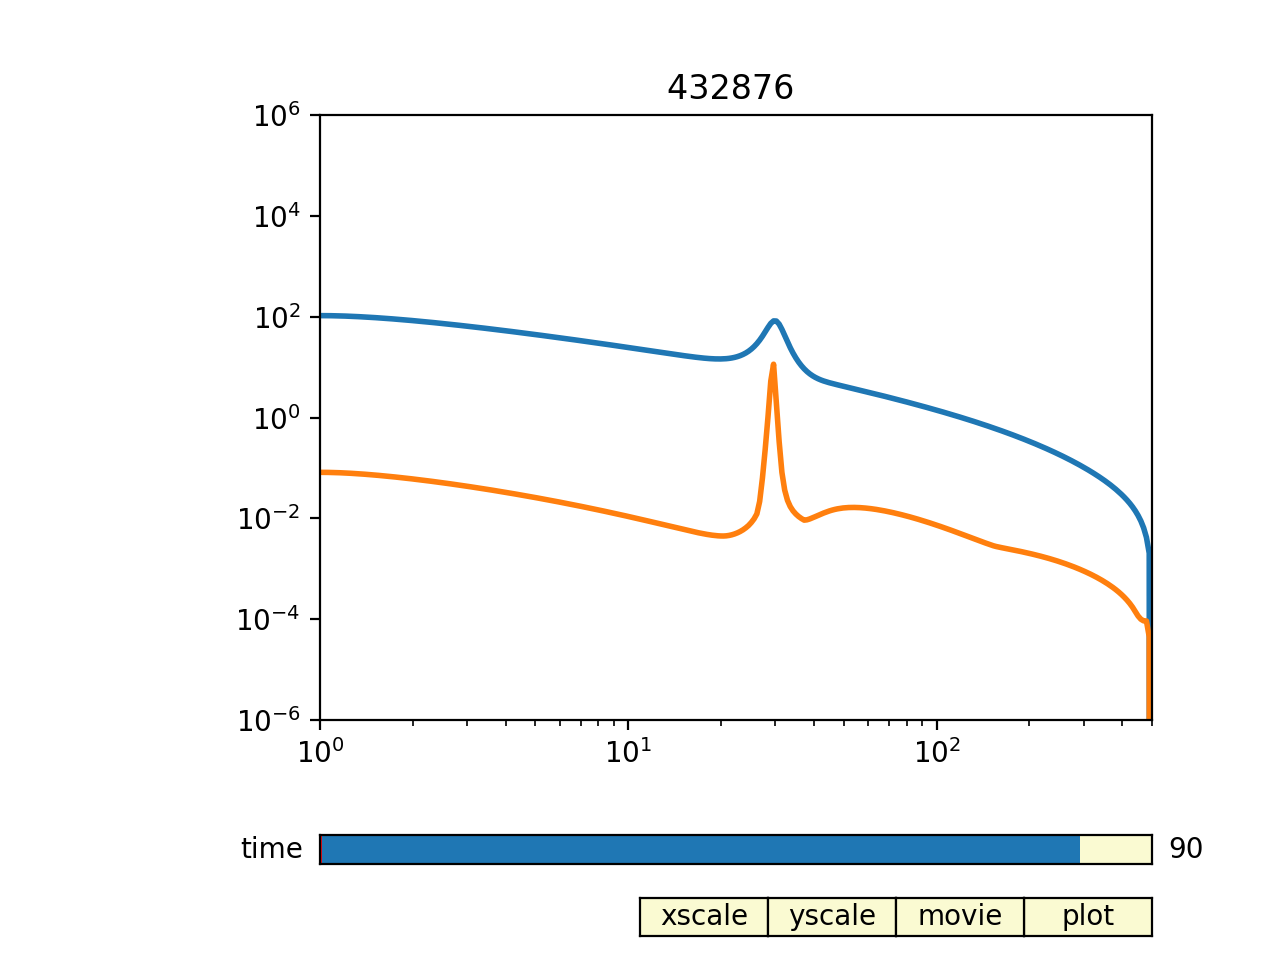

In [27]:
from widget import plotter
plotter(r/au,sig_g,data2=[sig_d],times=time/year,xlog=True,ylog=True,ylim=[1e-6,1e6],xlim=r[[0,-1]]/au);

## Reconstruction the size distribution

In [12]:
from twopoppy.distribution_reconstruction import reconstruct_size_distribution as rsd

In [13]:
rsd?

In [14]:
it  = -1
a = np.logspace(np.log10(a_0), np.log10(a_t.max())+1, 200)

Call the routine - don't worry about the warnings.

In [15]:
res = rsd(r, a, time[it], sig_g[it,:], sig_d[it,:], alpha, rho_s, T, M_star, v_frag, a_0=a_0)

sig_da = res[0] # we're really only interested in the size distribution

/opt/two-pop-py/twopoppy/distribution_reconstruction.py:30: RuntimeWarning: invalid value encountered in log10
  return 10**(np.interp(np.log10(x_int), np.log10(x), np.log10(R)))
/opt/two-pop-py/twopoppy/distribution_reconstruction.py:374: RuntimeWarning: invalid value encountered in sqrt
  (v / cs)**2 + 4 * (1 + d - p) * v / vk * alpha + 4 * alpha * sig_d / sig_g))
/opt/two-pop-py/twopoppy/distribution_reconstruction.py:412: RuntimeWarning: overflow encountered in power
  np.exp(A * ((r[mask] / ra)**p[mask] - 1.)))
/opt/two-pop-py/twopoppy/distribution_reconstruction.py:457: RuntimeWarning: invalid value encountered in double_scalars
  np.log(a[imax] / a[i_full])


Plot the particle size distribution

<IPython.core.display.Javascript object>


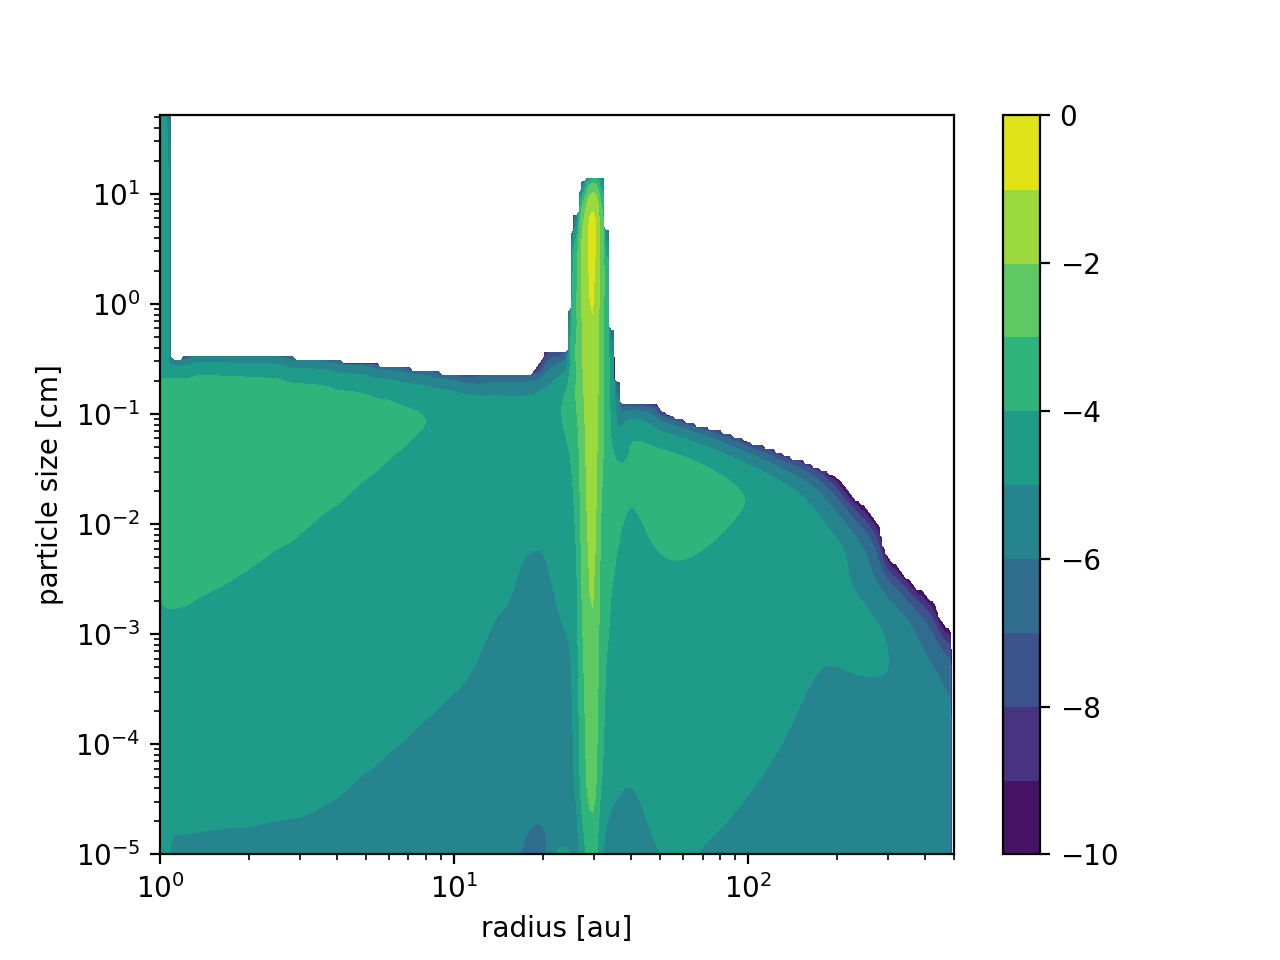

In [28]:
vmax = np.ceil(np.log10(sig_da.max()))

f,ax = plt.subplots()
cc = ax.contourf(r/au,a,np.log10(sig_da),np.arange(vmax-10,vmax+1))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('radius [au]')
ax.set_ylabel('particle size [cm]')
cb = plt.colorbar(cc,ax=ax)
#cb.set_label(r'$\Sigma_\mathrm{d,i}$ [g cm$^{-2}$]');

## `DustPy` teaser

In [17]:
import dustpy

In [18]:
sim = dustpy.sim.Simulation()

In [19]:
if os.path.isdir('output'):
    shutil.rmtree('output')
sim.initialize()


Checking parallel environments.
--> Using Numba  with   2 threads.
--> Using OpenMP with   1 thread.

'output/' does not exist.
Creating 'output/'.

Writing initial conditions.
Writing output file: 'output/data0000.hdf5'


In [20]:
sim.snapshots = np.array([0,1000*year])

In [21]:
sim.evolve()


Snapshot at t = 1.000E+03 yrs
Writing output file: 'output/data0002.hdf5'
Writing dump file: 'output/dustpy.dmp'

Execution Time: 0h 2min 58s


In [22]:
from dustpy.plotting import plot

2 files detected.


<IPython.core.display.Javascript object>


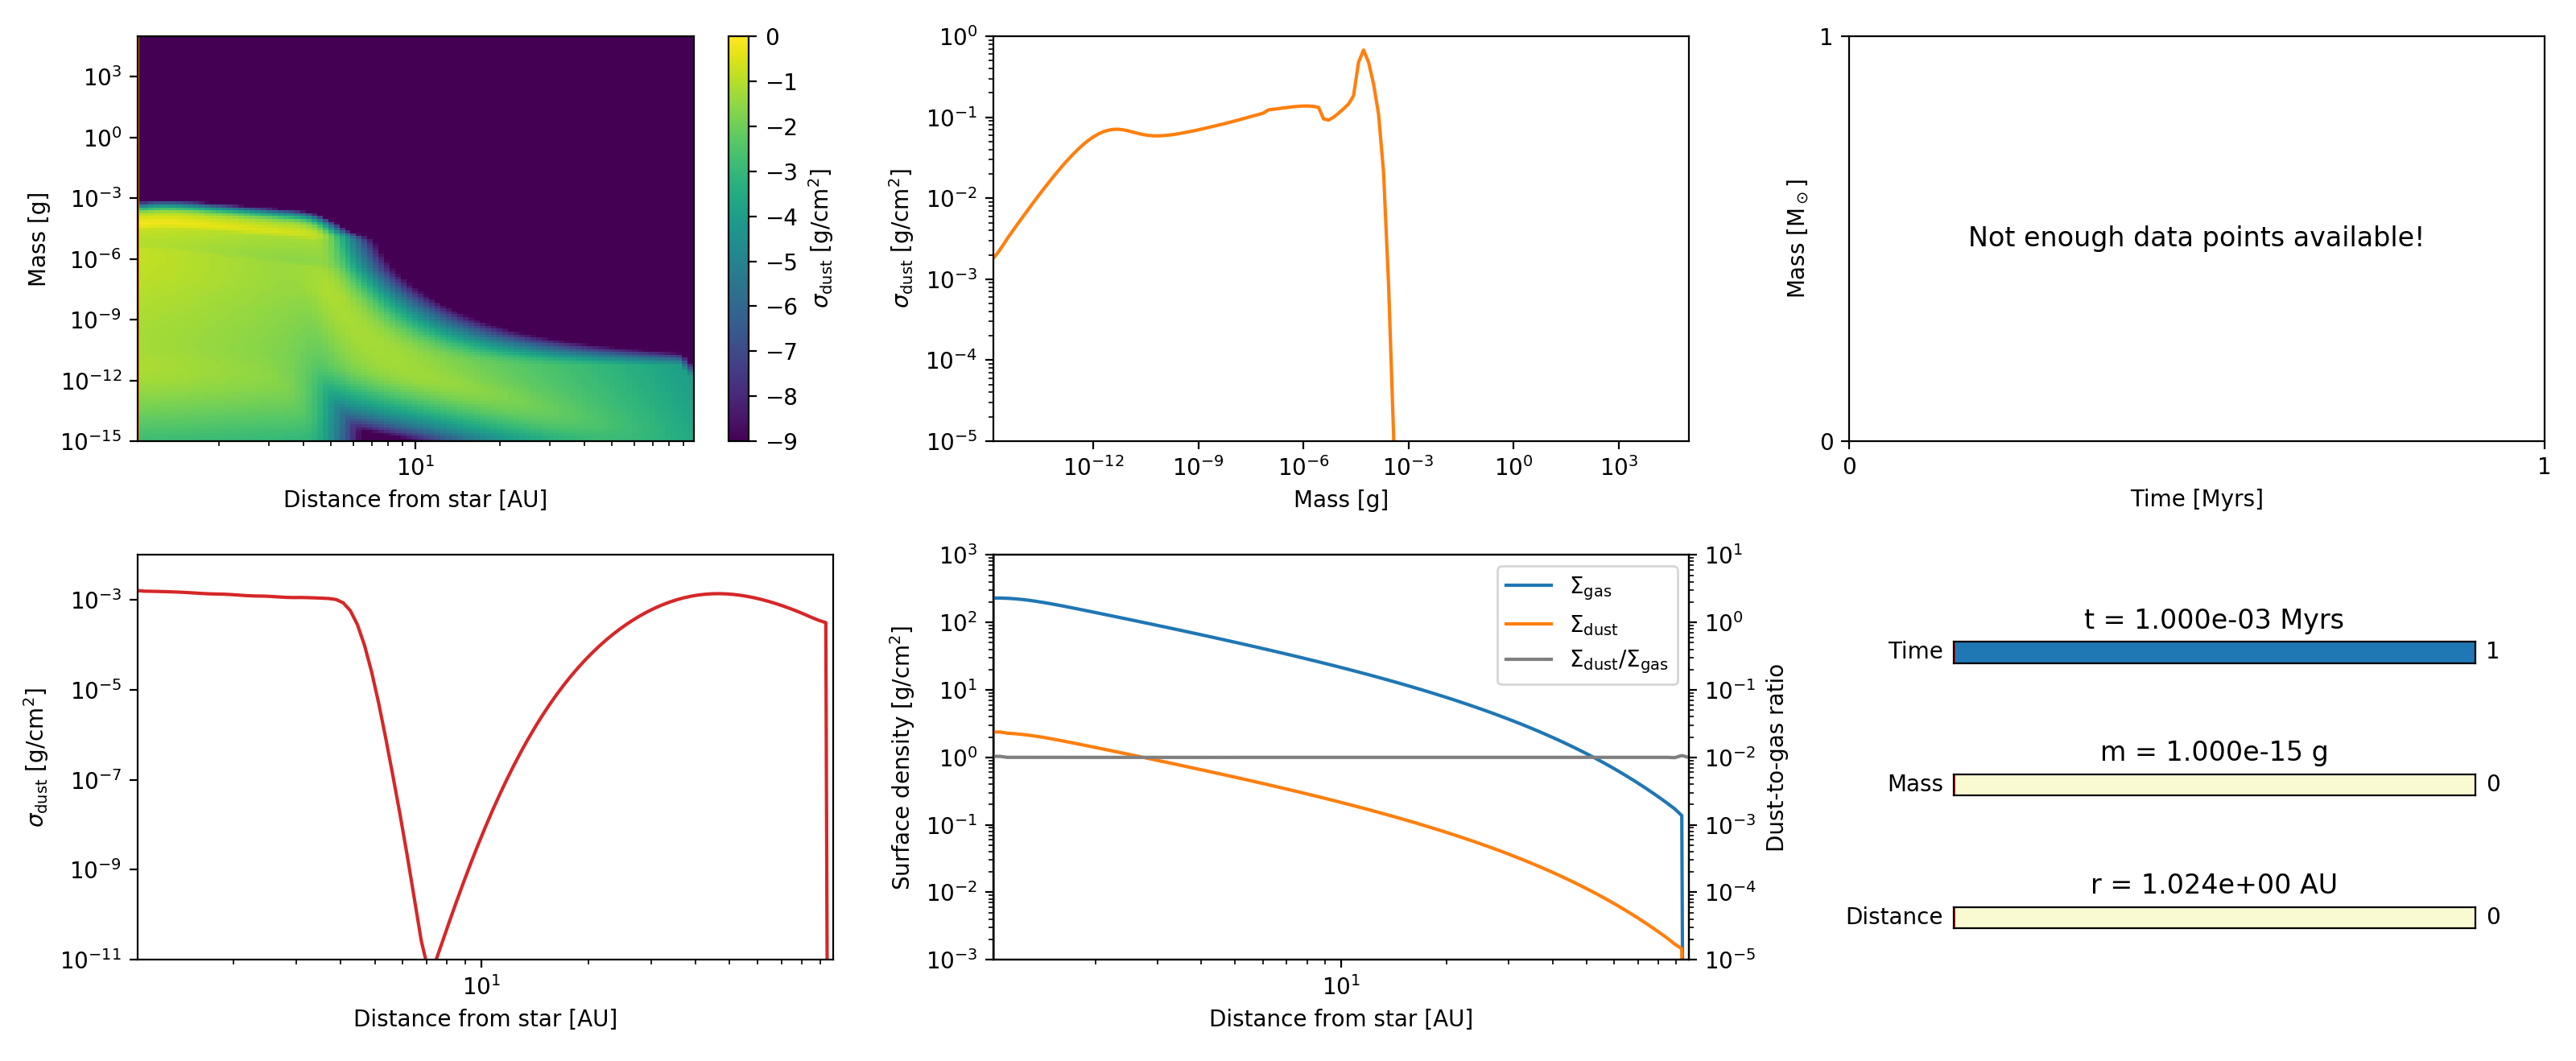

In [29]:
plot('output/')